In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# rcParams background color
plt.rcParams['figure.facecolor'] = 'white'

%matplotlib inline

In [2]:
# 1. LOAD DATA SIAP PAKAI
file_path = '../data/processed/master_data_modeled.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

print(f"✅ Data Berhasil Dimuat: {len(df)} baris")
print("Kolom Tersedia:")
print(df.columns.tolist())
print(f"Rentang Data: {df['date'].min()} s.d {df['date'].max()}")

✅ Data Berhasil Dimuat: 1561206 baris
Kolom Tersedia:
['race_id', 'date', 'rank', 'horse_name', 'odds', 'popularity', 'horse_weight', 'distance', 'horse_no', 'frame_no', 'time_seconds', 'rotation_days', 'last_rank', 'last_3_avg_rank', 'race_count', 'race_seq_since_break', 'jockey_venue_win_rate', 'trainer_venue_win_rate', 'jockey_dist_cat_win_rate', 'horse_name_dist_cat_win_rate', 'horse_name_surface_win_rate', 'jockey_venue_surface_win_rate', 'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 'race_class_id', 'sex_id', 'running_style_id', 'dist_cat_id']
Rentang Data: 1986-01-05 00:00:00 s.d 2021-07-31 00:00:00


In [12]:
# --- TAHAP 1: DEFINISI FITUR & TARGET ---
from sklearn.impute import SimpleImputer # Import Imputer

# 1. Buat Target
# Target 1: Win (Juara 1)
df['target_win'] = (df['rank'] == 1).astype(int)
# Target 2: Top 3 (Juara 1, 2, 3)
df['target_top3'] = (df['rank'] <= 3).astype(int)

# 2. Tentukan Fitur
# Pastikan membuang kolom string/objek yang tidak bisa di-scale
drop_cols = ['race_id', 'date', 'rank', 'target_win', 'target_top3', 'horse_no', 'horse_name', 'time_seconds','odds','popularity','running_style_id','jockey_venue_win_rate', 'trainer_venue_win_rate', 'jockey_dist_cat_win_rate', 'horse_name_dist_cat_win_rate', 'horse_name_surface_win_rate', 'jockey_venue_surface_win_rate'] 
# Catatan: Tambahkan kolom lain yang bukan angka jika masih error
features = [c for c in df.columns if c not in drop_cols and df[c].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Jumlah Fitur: {len(features)}")

# --- TAHAP 2: SPLITTING DATA (TIME SERIES) ---
val_start_date = '2019-01-01' # Sesuaikan tanggal split Anda
test_start_date = '2020-01-01'

# Split Dataframes
train_df = df[df['date'] < val_start_date]
val_df = df[(df['date'] >= val_start_date) & (df['date'] < test_start_date)]
test_df = df[df['date'] >= test_start_date]

print(f"Data Train : {len(train_df)} baris")
print(f"Data Val   : {len(val_df)} baris")
print(f"Data Test  : {len(test_df)} baris")

# Siapkan X (Raw)
X_train = train_df[features].copy()
X_val = val_df[features].copy()
X_test = test_df[features].copy()


Jumlah Fitur: 15
Data Train : 1441935 baris
Data Val   : 45635 baris
Data Test  : 73636 baris


In [4]:
import joblib
import os

# --- Load Classification Models (dari folder 'trained_models') ---

# CatBoost
catboost_top3 = joblib.load('./trained_models/model_CatBoost_Top3.pkl')
catboost_win  = joblib.load('./trained_models/model_CatBoost_Win.pkl')

# Gaussian Naive Bayes
gnb_top3 = joblib.load('./trained_models/model_GaussianNB_Top3.pkl')
gnb_win  = joblib.load('./trained_models/model_GaussianNB_Win.pkl')

# LightGBM
lgbm_top3 = joblib.load('./trained_models/model_LightGBM_Top3.pkl')
lgbm_win  = joblib.load('./trained_models/model_LightGBM_Win.pkl')

# Logistic Regression
lr_top3 = joblib.load('./trained_models/model_LogisticRegression_Top3.pkl')
lr_win  = joblib.load('./trained_models/model_LogisticRegression_Win.pkl')

# XGBoost
xgb_top3 = joblib.load('./trained_models/model_XGBoost_Top3.pkl')
xgb_win  = joblib.load('./trained_models/model_XGBoost_Win.pkl')


# --- Load Regression Models (dari folder 'trained_models_reg') ---

# KNN Regression
knn_reg = joblib.load('./trained_models_reg/model_KNN_reg.pkl')

# LightGBM Regression
lgbm_reg = joblib.load('./trained_models_reg/model_LGBM_reg.pkl')

# Random Forest Regression
rf_reg = joblib.load('./trained_models_reg/model_RandomForest_reg.pkl')

# Ridge Regression
ridge_reg = joblib.load('./trained_models_reg/model_Ridge_reg.pkl')

# XGBoost Regression
xgb_reg = joblib.load('./trained_models_reg/model_XGBoost_reg.pkl')

Memproses simulasi betting pada 5295 race...


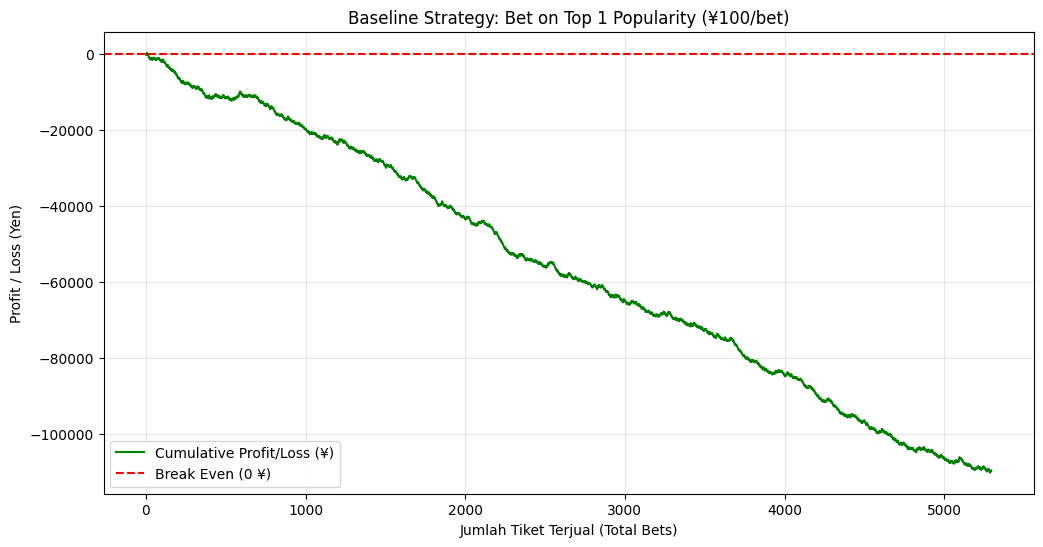

--- Hasil Baseline (By Popularity) ---
Strategy             : Bet Top 1 Popularity
Bet per Tiket        : ¥100
Total Tiket Dibeli   : 5295
Total Modal          : ¥529,500
Final Profit/Loss    : ¥-109,730
ROI (Return on Inv)  : -20.72%


In [5]:
def evaluate_baseline_popularity_yen(df, n_favorites=1, graph=True):
    """
    Baseline Strategy: 
    - Bertaruh pada kuda dengan Popularity terbaik (Pilihan penonton).
    - Satuan taruhan: 100 Yen per bet (Standar JRA).
    
    Parameters:
    - df: DataFrame (Data Test)
    - n_favorites: Jumlah kuda terpopuler yang dipasang per race (Default 1)
    - graph: Boolean untuk menampilkan plot
    """
    
    # Konfigurasi Taruhan
    BET_AMOUNT = 100  # 100 Yen per tiket
    
    money = 0
    cumulative_money = []
    bets_made = []
    total_bets = 0
    
    # Pastikan data terurut berdasarkan waktu agar grafik kumulatif valid
    df_sorted = df.sort_values(by=['date', 'race_id'])
    
    # Ambil daftar Race ID unik
    unique_races = df_sorted['race_id'].unique()
    print(f"Memproses simulasi betting pada {len(unique_races)} race...")
    
    for race_id in unique_races:
        # Ambil data satu race
        df_race = df_sorted[df_sorted['race_id'] == race_id]
        
        # --- LOGIKA BARU: Pilih berdasarkan 'popularity' ---
        # Mengambil n_favorites kuda dengan popularity terkecil (1 = terpopuler)
        # Pastikan kolom 'popularity' ada dan bertipe angka
        favorites = df_race.sort_values(by='popularity', ascending=True).head(n_favorites)
        
        bet_counter = 0
        
        for _, horse in favorites.iterrows():
            total_bets += 1
            bet_counter += 1
            
            # Cek Kemenangan (Rank 1)
            if horse['rank'] == 1:
                # Menang: Dapat (Odds x 100) - Modal 100
                # Contoh Odds 2.5: (2.5 * 100) - 100 = 150 Yen Profit
                profit = (horse['odds'] * BET_AMOUNT) - BET_AMOUNT
                money += profit
            else:
                # Kalah: Hilang modal 100 Yen
                money -= BET_AMOUNT
            
            cumulative_money.append(money)
        
        bets_made.append(bet_counter)

    # --- Visualisasi ---
    if graph:
        # 1. Plot Kumulatif Uang (Yen)
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_money, label='Cumulative Profit/Loss (¥)', color='green')
        plt.axhline(y=0, color='red', linestyle='--', label='Break Even (0 ¥)')
        plt.title(f'Baseline Strategy: Bet on Top {n_favorites} Popularity (¥100/bet)')
        plt.xlabel('Jumlah Tiket Terjual (Total Bets)')
        plt.ylabel('Profit / Loss (Yen)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 2. Plot Jumlah Bet per Race (Opsional, biasanya flat jika n_favorites=1)
        # plt.figure(figsize=(10, 4))
        # plt.plot(bets_made)
        # plt.title('Bets per Race')
        # plt.show()
        
    # --- Statistik Akhir ---
    print('--- Hasil Baseline (By Popularity) ---')
    print(f'Strategy             : Bet Top {n_favorites} Popularity')
    print(f'Bet per Tiket        : ¥{BET_AMOUNT}')
    print(f'Total Tiket Dibeli   : {total_bets}')
    print(f'Total Modal          : ¥{total_bets * BET_AMOUNT:,.0f}')
    print(f'Final Profit/Loss    : ¥{money:,.0f}')
    
    if total_bets > 0:
        roi = (money / (total_bets * BET_AMOUNT)) * 100
        print(f'ROI (Return on Inv)  : {roi:.2f}%')

# --- CARA PENGGUNAAN ---
# Jalankan pada data test (X_test digabung dengan target/meta info atau df test asli)
# Pastikan 'test_df' memiliki kolom: 'race_id', 'date', 'popularity', 'rank', 'odds'

evaluate_baseline_popularity_yen(test_df, n_favorites=1)

## Strategy 1: Buy Top Prediction

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def simple_class_strategy_yen(df_test, model_pred, graph=True):
    """
    STRATEGY FINAL: 'Elite Sniper'
    Fokus: Membuang noise probabilitas rendah & odds tidak masuk akal.
    
    Syarat Betting Diperketat:
    1. MIN_PROB >= 0.30 (30%): Kita hanya pasang jika model YAKIN kuda ini calon juara.
       (Ini akan memotong ribuan bet 'iseng' pada kuda odds tinggi).
    2. MAX_ODDS <= 15.0: Hindari 'Long Shot' yang sering menipu EV.
    3. EV > 1.1: Tetap cari value.
    """
    
    df_backtest = df_test.copy()
    
    # 1. Masukkan Probabilitas
    df_backtest['prob_win'] = model_pred 
    
    # 2. Hitung EV
    df_backtest['ev'] = df_backtest['prob_win'] * df_backtest['odds']
    
    df_backtest['ActualWin'] = (df_backtest['rank'] == 1).astype(int)
    
    if 'date' in df_backtest.columns:
        df_backtest = df_backtest.sort_values(by=['date', 'race_id'])

    # --- KONFIGURASI ELITE ---
    BET_AMOUNT = 100
    
    # [FILTER UTAMA]: Potong semua probabilitas sampah
    # Kuda dengan chance < 30% di race 16 kuda seringkali cuma tebakan acak model
    MIN_PROB = 0.30  
    
    # [FILTER KEDUA]: Jangan tergiur odds raksasa
    # Kita main aman di area Favorite - Middle
    MAX_ODDS = 15.0
    
    # [FILTER KETIGA]: Margin of Safety
    MIN_EV = 1.15
    
    money = 0
    bets_made_count = []
    cumulative_money = [0]
    
    unique_races = df_backtest['race_id'].unique()
    races_skipped = 0
    
    for race_id in unique_races:
        temp_df = df_backtest[df_backtest['race_id'] == race_id]
        
        # --- LOGIKA STRICT ---
        candidates = temp_df[
            (temp_df['prob_win'] >= MIN_PROB) &  # Model HARUS Yakin (30%+)
            (temp_df['odds'] <= MAX_ODDS) &      # Odds Wajar
            (temp_df['ev'] > MIN_EV)             # Menguntungkan
        ]
        
        if len(candidates) > 0:
            # Ambil 1 kuda dengan PROBABILITAS TERTINGGI (Paling Yakin)
            # (Di strategi ini, Confidence > EV karena kita menghindari risk)
            best_bet = candidates.sort_values(by='prob_win', ascending=False).head(1)
            
            cost = BET_AMOUNT
            if best_bet['ActualWin'].values[0] == 1:
                revenue = best_bet['odds'].values[0] * BET_AMOUNT
            else:
                revenue = 0
            
            profit = revenue - cost
            money += profit
            bets_made_count.append(1)
        else:
            bets_made_count.append(0)
            races_skipped += 1
            
        cumulative_money.append(money)
    
    # --- OUTPUT ---
    total_tickets = sum(bets_made_count)
    total_invested = total_tickets * BET_AMOUNT
    roi = (money / total_invested * 100) if total_invested > 0 else 0
    
    if graph:
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_money, color='blue', linewidth=2)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title(f'Elite Sniper Strategy (Prob>{MIN_PROB}, Odds<{MAX_ODDS})')
        plt.xlabel('Race Index')
        plt.ylabel('Profit (Yen)')
        plt.grid(True, alpha=0.3)
        plt.show()

    print(f'--- Hasil Elite Sniper ---')
    print(f'Total Race         : {len(unique_races)}')
    print(f'Race Di-Skip       : {races_skipped}')
    print(f'Tiket Dibeli       : {total_tickets}')
    print(f'Final Profit       : ¥{money:,.0f}')
    print(f'ROI                : {roi:.2f}%')

    return money, bets_made_count

## Strategy 2: Buy Fastest Timing

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def simple_reg_strategy_yen(df_test, model_pred, graph=True):
    """
    Backtest strategi betting untuk Model Regresi.
    Strategi: Bet pada kuda dengan prediksi waktu tercepat (nilai terkecil).
    
    Parameters:
    - df_test: DataFrame data uji (harus punya kolom 'race_id', 'odds', 'rank')
    - model_pred: Array hasil prediksi (waktu/seconds) dari model regresi
    - graph: Boolean untuk menampilkan plot
    """
    
    # 1. Siapkan Dataframe
    # Copy agar data asli aman
    df_backtest = df_test.copy()
    
    # Masukkan hasil prediksi waktu ke dataframe
    # Asumsi: model_pred adalah array numpy atau Series yang urutannya sama dengan df_test
    df_backtest['pred_time'] = model_pred

    # Pastikan data urut berdasarkan waktu race (untuk grafik kumulatif yang logis)
    if 'date' in df_backtest.columns:
        df_backtest = df_backtest.sort_values(by=['date', 'race_id'])
    
    # Filter kolom penting
    # ActualWin: 1 jika rank == 1, 0 jika kalah
    df_backtest['ActualWin'] = (df_backtest['rank'] == 1).astype(int)

    # Konfigurasi Bet
    BET_AMOUNT = 100  # Standar JRA 100 Yen
    
    money = 0
    cumulative_money = [0]
    bets_made_count = []
    
    unique_races = df_backtest['race_id'].unique()
    print(f"Melakukan Backtest Regresi pada {len(unique_races)} race...")

    for race_id in unique_races:
        # Ambil data satu race
        temp_df = df_backtest[df_backtest['race_id'] == race_id]

        # --- STRATEGI REGRESI ---
        # Cari nilai prediksi waktu TERKECIL (Tercepat)
        min_time = temp_df['pred_time'].min()
        
        # Pilih kuda yang memiliki waktu tercepat tersebut
        # (Bisa lebih dari 1 jika ada prediksi waktu yang persis sama)
        bets = temp_df[temp_df['pred_time'] == min_time]
        
        num_bets = len(bets)
        
        # Hitung Keuangan
        if num_bets > 0:
            # 1. Bayar Modal Taruhan
            cost = num_bets * BET_AMOUNT
            
            # 2. Hitung Kemenangan
            # Jika kuda yang kita pilih Rank 1, kita dapat Odds * 100
            winners = bets[bets['rank'] == 1]
            revenue = winners['odds'].sum() * BET_AMOUNT
            
            # 3. Update Saldo
            profit = revenue - cost
            money += profit
        
        cumulative_money.append(money)
        bets_made_count.append(num_bets)
    
    # --- Visualisasi ---
    if graph:
        # Plot Saldo
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_money, color='purple')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Cumulative Profit/Loss (Regression Strategy)')
        plt.xlabel('Jumlah Race')
        plt.ylabel('Profit (Yen)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot Jumlah Bet (seharusnya rata-rata 1, kecuali ada tie)
        # plt.figure(figsize=(10, 4))
        # plt.plot(bets_made_count)
        # plt.title('Bets Made per Race')
        # plt.show()

    # --- Statistik Akhir ---
    total_tickets = sum(bets_made_count)
    total_invested = total_tickets * BET_AMOUNT
    
    print('--- Hasil Backtest (Regresi) ---')
    print(f'Final Money (Profit) : ¥{money:,.0f}')
    print(f'Total Tiket Dibeli   : {total_tickets}')
    print(f'Total Modal          : ¥{total_invested:,.0f}')
    
    if total_invested > 0:
        roi = (money / total_invested) * 100
        print(f'ROI                  : {roi:.2f}%')

    return money, bets_made_count

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def top3_strategy_yen(df_test, model_pred, graph=True):
    """
    Backtest Strategi Top 3:
    - Jika model memprediksi kuda masuk Top 3 (Label 1), kita pasang taruhan WIN.
    - Payout hanya terjadi jika kuda tersebut benar-benar Juara 1 (Rank 1).
    """
    
    # 1. Siapkan Dataframe
    df_backtest = df_test.copy()
    
    # Masukkan hasil prediksi ke dataframe
    # Asumsi: model_pred adalah array 0/1 dimana 1 artinya diprediksi Top 3
    df_backtest['pred_top3'] = model_pred
    
    # Pastikan data terurut
    if 'date' in df_backtest.columns:
        df_backtest = df_backtest.sort_values(by=['date', 'race_id'])
        
    # Buat kolom indikator kemenangan aktual (Hanya Rank 1 yang dihitung Win)
    df_backtest['ActualWin'] = (df_backtest['rank'] == 1).astype(int)

    # Konfigurasi Bet
    BET_AMOUNT = 100  # Standar JRA 100 Yen
    
    money = 0
    cumulative_money = [0]
    bets_made_count = []
    
    unique_races = df_backtest['race_id'].unique()
    print(f"Melakukan Backtest (Top 3 Signal -> Win Bet) pada {len(unique_races)} race...")

    for race_id in unique_races:
        # Ambil data satu race
        temp_df = df_backtest[df_backtest['race_id'] == race_id]

        # --- STRATEGI ---
        # Pasang taruhan pada SEMUA kuda yang diprediksi masuk Top 3
        bets = temp_df[temp_df['pred_top3'] == 1]
        
        num_bets = len(bets)
        
        if num_bets > 0:
            # 1. Modal (Cost)
            # Kita mungkin memasang lebih dari 1 kuda per race
            cost = num_bets * BET_AMOUNT
            
            # 2. Payout (Revenue)
            # Kita hanya dapat uang jika salah satu kuda pilihan kita Rank 1
            # Rumus: Odds * 100
            winners = bets[bets['ActualWin'] == 1]
            revenue = winners['odds'].sum() * BET_AMOUNT
            
            # 3. Profit/Loss
            profit = revenue - cost
            money += profit
        
        cumulative_money.append(money)
        bets_made_count.append(num_bets)
    
    # --- Visualisasi ---
    if graph:
        # Plot Kumulatif Uang
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_money, color='orange')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Cumulative Profit/Loss (Top 3 Signal Strategy)')
        plt.xlabel('Jumlah Race')
        plt.ylabel('Profit (Yen)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot Jumlah Bet per Race
        plt.figure(figsize=(12, 4))
        plt.plot(bets_made_count, color='gray', alpha=0.5)
        plt.title('Jumlah Kuda yang Dipasang per Race (Predicted Top 3)')
        plt.xlabel('Race Index')
        plt.ylabel('Jumlah Tiket')
        plt.show()

    # --- Statistik Akhir ---
    total_tickets = sum(bets_made_count)
    total_invested = total_tickets * BET_AMOUNT
    
    print('--- Hasil Backtest (Top 3 Strategy) ---')
    print(f'Final Money (Profit) : ¥{money:,.0f}')
    print(f'Total Tiket Dibeli   : {total_tickets}')
    print(f'Total Modal          : ¥{total_invested:,.0f}')
    
    if total_invested > 0:
        roi = (money / total_invested) * 100
        print(f'ROI                  : {roi:.2f}%')
        
    return money, bets_made_count

## Strategy 4: Buy Only Fast and Good

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def hybrid_strategy_yen(df_test, pred_win, pred_top3, pred_reg, graph=True):
    """
    Backtest Hybrid Strategy:
    Betting hanya dilakukan jika kuda memenuhi 3 kriteria sekaligus:
    1. Prediksi Model Win = 1
    2. Prediksi Model Top3 = 1
    3. Prediksi Model Regresi = Waktu Tercepat di race tersebut
    """
    
    # 1. Siapkan Dataframe
    df_backtest = df_test.copy()
    
    # Masukkan ketiga hasil prediksi ke dataframe
    df_backtest['pred_win'] = pred_win
    df_backtest['pred_top3'] = pred_top3
    df_backtest['pred_time'] = pred_reg
    
    # Pastikan data terurut
    if 'date' in df_backtest.columns:
        df_backtest = df_backtest.sort_values(by=['date', 'race_id'])
        
    # Kolom Actual Win (Rank 1)
    df_backtest['ActualWin'] = (df_backtest['rank'] == 1).astype(int)

    # Konfigurasi Bet
    BET_AMOUNT = 100  # Standar JRA 100 Yen
    
    money = 0
    cumulative_money = [0]
    bets_made_count = []
    
    unique_races = df_backtest['race_id'].unique()
    print(f"Melakukan Backtest Hybrid (Win + Top3 + Speed) pada {len(unique_races)} race...")

    for race_id in unique_races:
        # Ambil data satu race
        temp_df = df_backtest[df_backtest['race_id'] == race_id]

        # --- FILTER HYBRID ---
        # 1. Filter Prediksi Win & Top 3
        class_filter = (temp_df['pred_win'] == 1) & (temp_df['pred_top3'] == 1)
        
        # 2. Filter Prediksi Waktu Tercepat (Regresi)
        min_time = temp_df['pred_time'].min()
        time_filter = (temp_df['pred_time'] == min_time)
        
        # Gabungkan semua filter
        bets = temp_df[class_filter & time_filter]
        
        num_bets = len(bets)
        
        if num_bets > 0:
            # Hitung Biaya
            cost = num_bets * BET_AMOUNT
            
            # Hitung Revenue (Hanya jika Rank 1)
            winners = bets[bets['ActualWin'] == 1]
            revenue = winners['odds'].sum() * BET_AMOUNT
            
            # Profit/Loss
            profit = revenue - cost
            money += profit
        
        cumulative_money.append(money)
        bets_made_count.append(num_bets)
    
    # --- Visualisasi ---
    if graph:
        # Plot Saldo
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_money, color='magenta', linewidth=2)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Cumulative Profit/Loss (Hybrid Strategy)')
        plt.xlabel('Jumlah Race')
        plt.ylabel('Profit (Yen)')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot Jumlah Bet (Akan jarang terjadi bet karena filter ketat)
        plt.figure(figsize=(12, 4))
        plt.plot(bets_made_count, color='black', alpha=0.3)
        plt.title('Bets Made per Race (Hybrid)')
        plt.xlabel('Race Index')
        plt.ylabel('Jumlah Tiket')
        plt.show()

    # --- Statistik Akhir ---
    total_tickets = sum(bets_made_count)
    total_invested = total_tickets * BET_AMOUNT
    
    print('--- Hasil Backtest (Hybrid Strategy) ---')
    print(f'Final Money (Profit) : ¥{money:,.0f}')
    print(f'Total Tiket Dibeli   : {total_tickets}')
    print(f'Total Modal          : ¥{total_invested:,.0f}')
    
    if total_invested > 0:
        roi = (money / total_invested) * 100
        print(f'ROI                  : {roi:.2f}%')
    else:
        print('ROI                  : 0% (Tidak ada bet yang memenuhi kriteria)')

    return money, bets_made_count

In [10]:
# Dictionary untuk Model WIN (Juara 1)
models_win_dict = {
    'CatBoost': catboost_win,
    'GaussianNB': gnb_win,
    'LightGBM': lgbm_win,
    'LogisticRegression': lr_win,
    'XGBoost': xgb_win
}

# Dictionary untuk Model TOP 3
models_top3_dict = {
    'CatBoost': catboost_top3,
    'GaussianNB': gnb_top3,
    'LightGBM': lgbm_top3,
    'LogisticRegression': lr_top3,
    'XGBoost': xgb_top3
}

# Dictionary untuk Model REGRESI (Waktu/Speed)
models_reg_dict = {
    'KNN': knn_reg,
    'LightGBM': lgbm_reg,
    'RandomForest': rf_reg,
    'Ridge': ridge_reg,
    'XGBoost': xgb_reg
}

=== EVALUASI STRATEGY 1: WIN MODEL ===

Running: CatBoost...


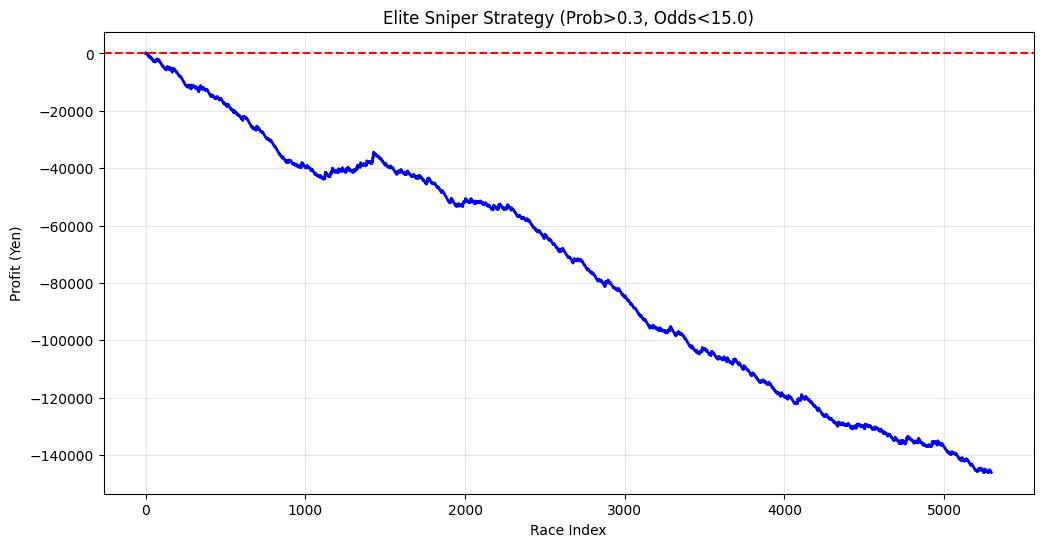

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 50
Tiket Dibeli       : 5245
Final Profit       : ¥-146,090
ROI                : -27.85%
Running: GaussianNB...


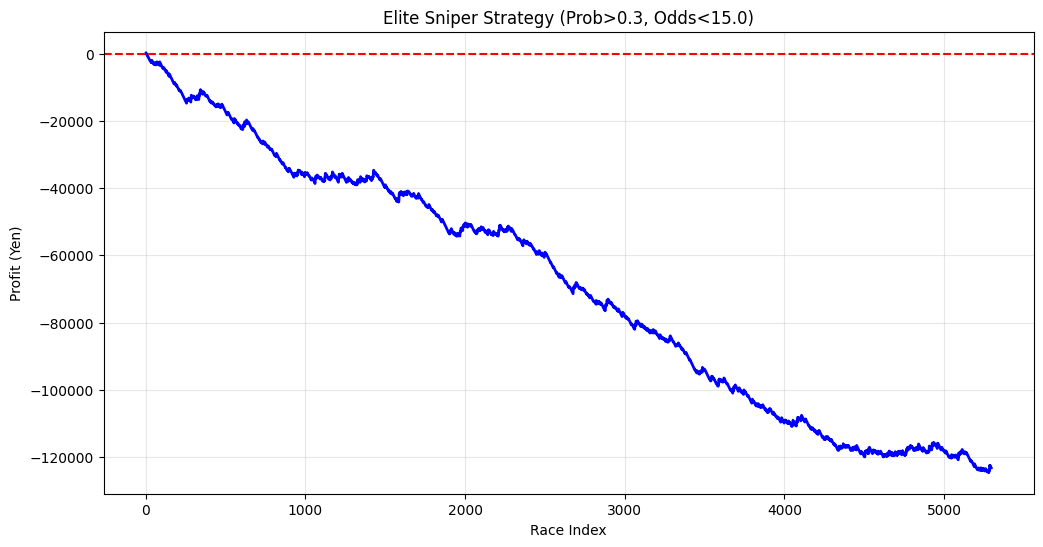

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 1
Tiket Dibeli       : 5294
Final Profit       : ¥-123,210
ROI                : -23.27%
Running: LightGBM...


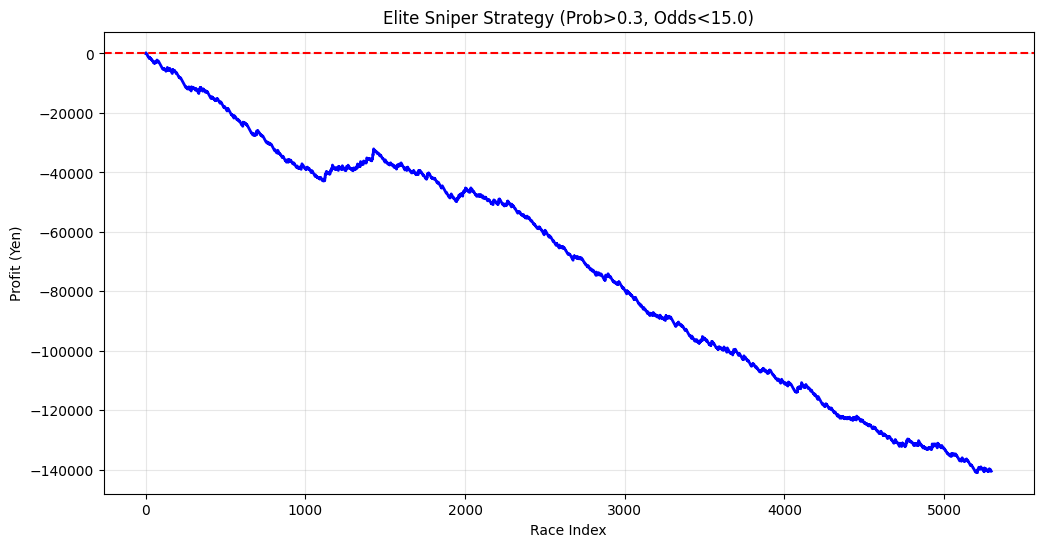

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 56
Tiket Dibeli       : 5239
Final Profit       : ¥-140,480
ROI                : -26.81%
Running: LogisticRegression...


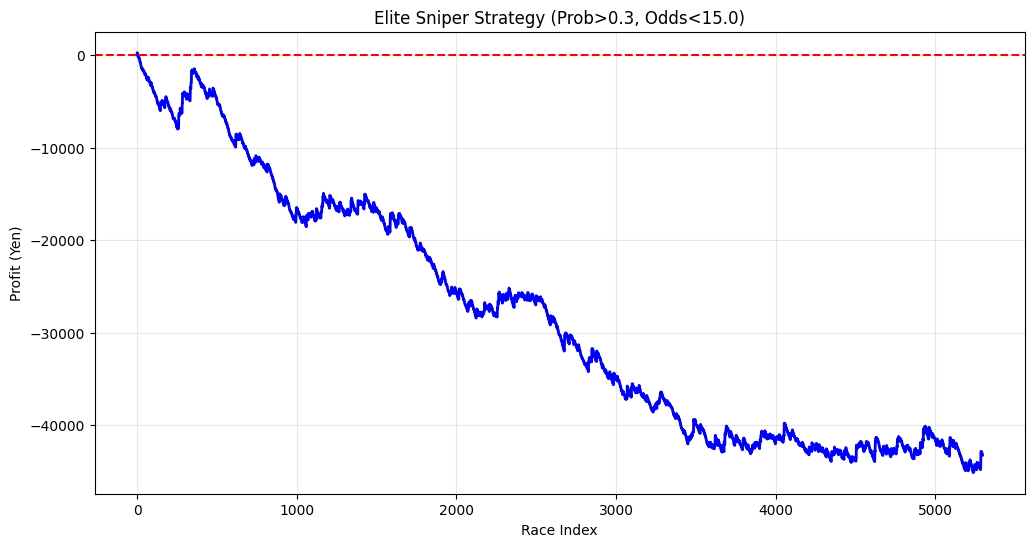

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 2248
Tiket Dibeli       : 3047
Final Profit       : ¥-43,240
ROI                : -14.19%
Running: XGBoost...


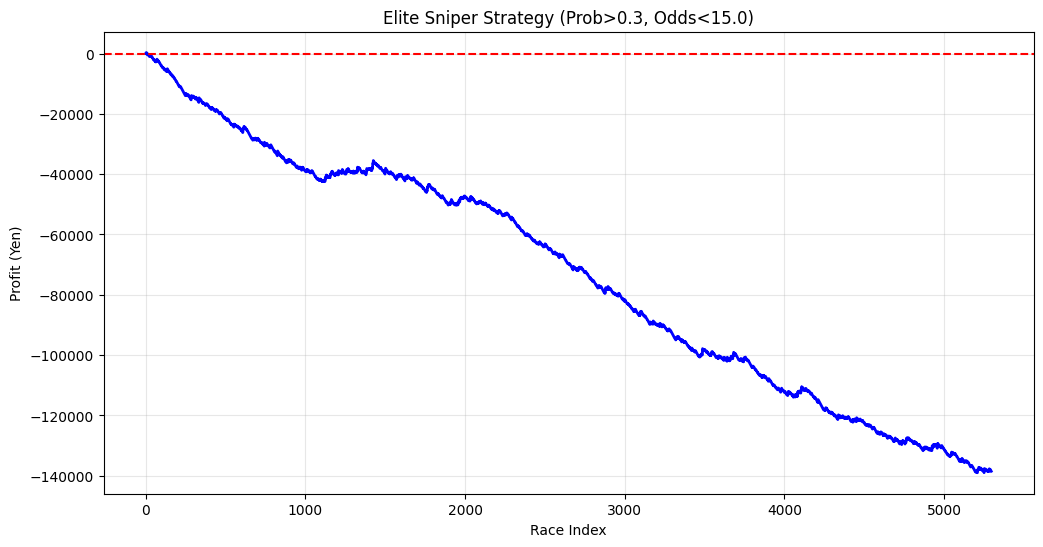

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 216
Tiket Dibeli       : 5079
Final Profit       : ¥-138,530
ROI                : -27.28%

=== REKAP HASIL STRATEGY 1 ===


,Model,Money (¥),Total Bets,ROI
0,CatBoost,-146090.0,5245,-27.85%
1,GaussianNB,-123210.0,5294,-23.27%
2,LightGBM,-140480.0,5239,-26.81%
3,LogisticRegression,-43240.0,3047,-14.19%
4,XGBoost,-138530.0,5079,-27.28%


In [13]:
import pandas as pd

# 1. Buat DataFrame untuk menyimpan hasil
strat1_results = pd.DataFrame(columns=['Model', 'Money (¥)', 'Total Bets', 'ROI'])

print("=== EVALUASI STRATEGY 1: WIN MODEL ===\n")

# 2. Loop melalui setiap model di dictionary models_win_dict
for model_name, model in models_win_dict.items():
    
    print(f"Running: {model_name}...")
    
    # A. Lakukan Prediksi (Karena dictionary berisi model, bukan prediksi)
    # Pastikan X_test sudah didefinisikan dari langkah sebelumnya
    y_pred = model.predict(X_test)
    
    # B. Jalankan Backtest (Gunakan fungsi yen yang baru dibuat)
    # Ubah graph=False jika tidak ingin melihat grafik per model
    money, bets_made_counts = simple_class_strategy_yen(test_df, y_pred, graph=True)
    
    # C. Hitung total bet dan ROI
    total_bets = sum(bets_made_counts)
    total_invested = total_bets * 100
    roi = (money / total_invested * 100) if total_invested > 0 else 0
    
    # D. Simpan ke DataFrame
    strat1_results.loc[len(strat1_results)] = [
        model_name, 
        money, 
        total_bets, 
        f"{roi:.2f}%"
    ]

# 3. Tampilkan Tabel Hasil Akhir
print("\n=== REKAP HASIL STRATEGY 1 ===")
strat1_results

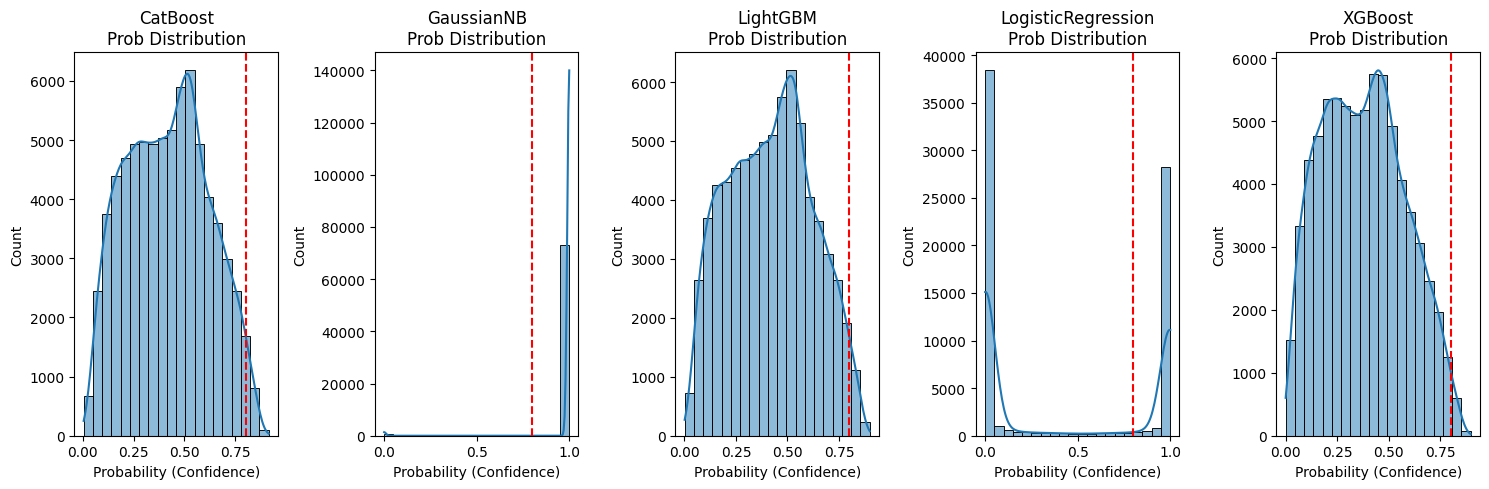

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def check_probability_distribution(models_dict, X_test):
    plt.figure(figsize=(15, 5))
    
    for i, (name, model) in enumerate(models_dict.items()):
        try:
            # Ambil probabilitas
            probs = model.predict_proba(X_test)[:, 1]
            
            plt.subplot(1, len(models_dict), i+1)
            sns.histplot(probs, bins=20, kde=True)
            plt.title(f"{name}\nProb Distribution")
            plt.xlabel("Probability (Confidence)")
            plt.ylabel("Count")
            plt.axvline(0.8, color='r', linestyle='--', label='Threshold 0.8')
            
        except:
            print(f"Skipping {name} (No predict_proba)")
            
    plt.tight_layout()
    plt.show()

# Panggil fungsi ini
check_probability_distribution(models_win_dict, X_test)

=== EVALUASI STRICT VALUE (EV > 1.1) ===

Processing: CatBoost...


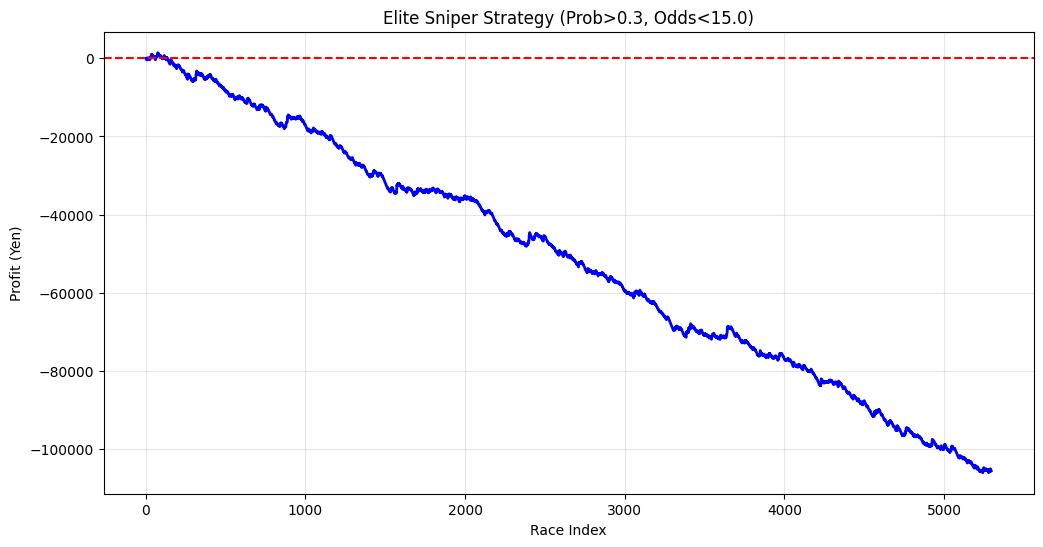

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 4
Tiket Dibeli       : 5291
Final Profit       : ¥-105,620
ROI                : -19.96%
Processing: GaussianNB...


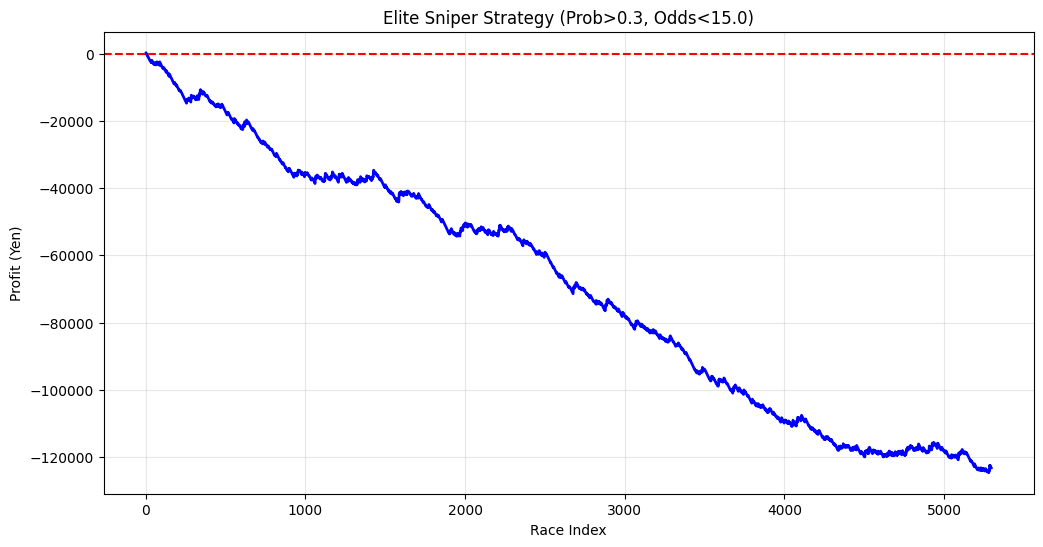

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 1
Tiket Dibeli       : 5294
Final Profit       : ¥-123,210
ROI                : -23.27%
Processing: LightGBM...


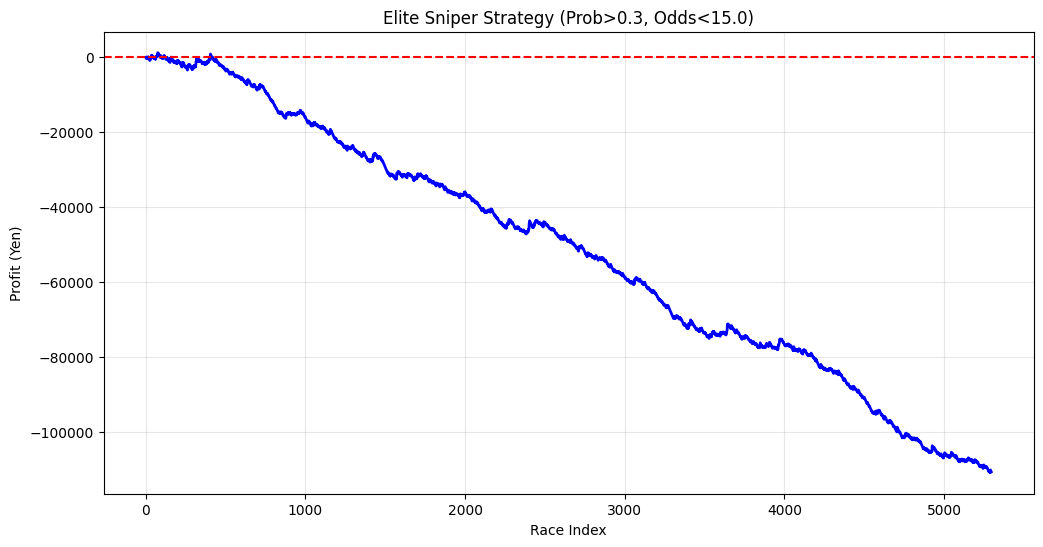

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 3
Tiket Dibeli       : 5292
Final Profit       : ¥-110,620
ROI                : -20.90%
Processing: LogisticRegression...


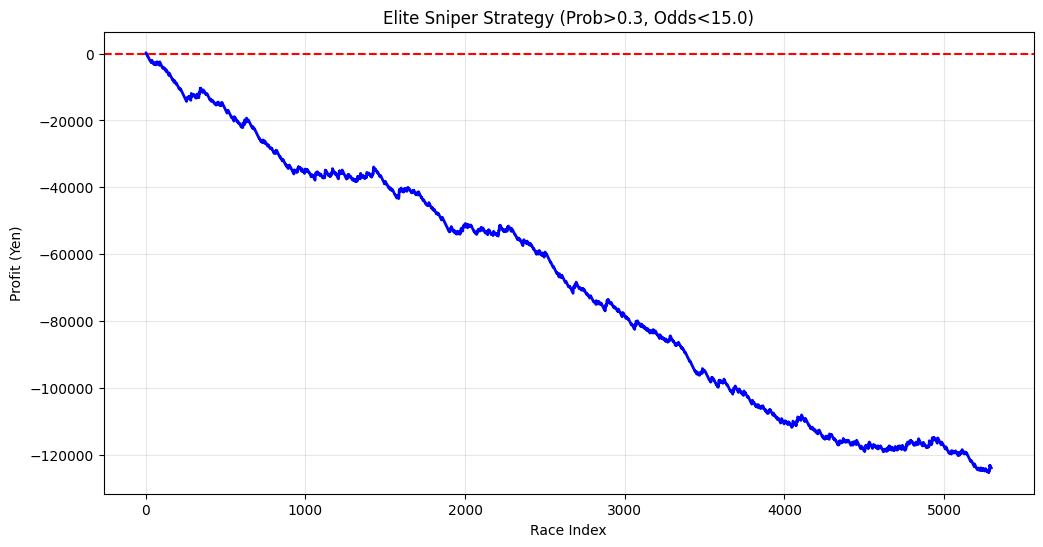

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 1
Tiket Dibeli       : 5294
Final Profit       : ¥-123,930
ROI                : -23.41%
Processing: XGBoost...


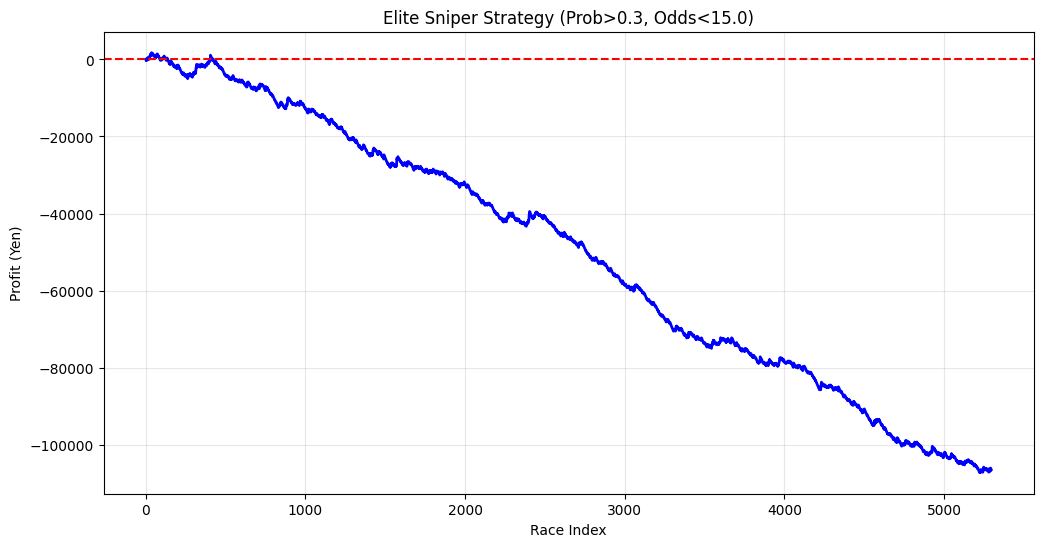

--- Hasil Elite Sniper ---
Total Race         : 5295
Race Di-Skip       : 7
Tiket Dibeli       : 5288
Final Profit       : ¥-106,510
ROI                : -20.14%


,Model,Money,Total Bets,ROI
0,CatBoost,-105620.0,5291,-19.96%
1,GaussianNB,-123210.0,5294,-23.27%
2,LightGBM,-110620.0,5292,-20.90%
3,LogisticRegression,-123930.0,5294,-23.41%
4,XGBoost,-106510.0,5288,-20.14%


In [ ]:
strat_value_results = pd.DataFrame(columns=['Model', 'Money', 'Total Bets', 'ROI'])

print("=== EVALUASI STRICT VALUE (EV > 1.1) ===\n")

for model_name, model in models_win_dict.items():
    print(f"Processing: {model_name}...")
    
    try:
        # 1. AMBIL PROBABILITAS (Kolom index 1)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # 2. JALANKAN STRATEGY (Fungsi yang sudah dimodifikasi)
        money, bets = simple_class_strategy_yen(test_df, y_prob, graph=True)
        
        # 3. REKAP
        total_bets = sum(bets)
        total_invested = total_bets * 100
        roi = (money / total_invested * 100) if total_invested > 0 else 0
        
        strat_value_results.loc[len(strat_value_results)] = [
            model_name, money, total_bets, f"{roi:.2f}%"
        ]
        
    except Exception as e:
        print(f"Model {model_name} error: {e}")

strat_value_results